In [1]:
import zeus21
from matplotlib import pyplot as plt
import numpy as np
from zeus21 import LIM
import matplotlib as mpl
from tqdm import tqdm

import scipy.fftpack as fft
from scipy import ndimage

import functools

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [2]:
# define all the input params
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
CosmoParams_use,ClassyCosmo_use, CorrFclass_use ,HMFintclass_use =  zeus21.cosmo_wrapper(CosmoParams_input)

AstroParams = zeus21.Astro_Parameters(CosmoParams_use)
AstroParams_stoch = zeus21.Astro_Parameters(CosmoParams_use,STOCHASTICITY=True)

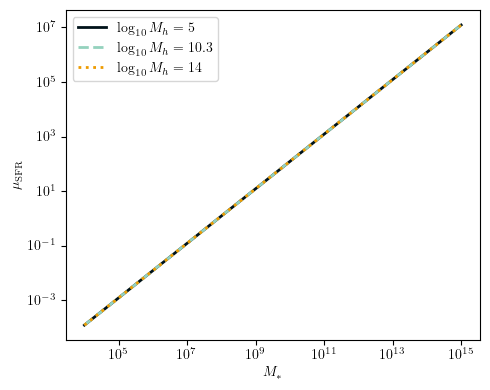

In [3]:
M = np.logspace(4,15,147)
Mh = HMFintclass_use.Mhtab
mu_SFR = M[:,np.newaxis] / Mh[np.newaxis,:] * (zeus21.sfrd.dMh_dt(AstroParams_stoch, CosmoParams_use, HMFintclass_use, Mh, 10.))[np.newaxis,:]

# mu_SFR_21cmf = M[:,np.newaxis] * zeus21.cosmology.Hubinvyr(CosmoParams_use,10.) / 0.5

plt.figure(figsize=(5,4))
# plt.loglog(M,mu_SFR_21cmf[:,0],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[0]),1),color=colors[0])
plt.loglog(M,mu_SFR[:,0],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[0]),1),color=colors[0])
plt.loglog(M,mu_SFR[:,20],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[20]),1),ls='--',color=colors[3])
plt.loglog(M,mu_SFR[:,-1],label=r'$\log_{10}M_h = %g$'%round(np.log10(Mh[-1]),1),ls=':',color=colors[5])
plt.legend()
plt.xlabel(r'$M_*$')
plt.ylabel(r'$\mu_{\rm SFR}$')
plt.tight_layout()
plt.savefig('./mu_SFR.png')
plt.show()


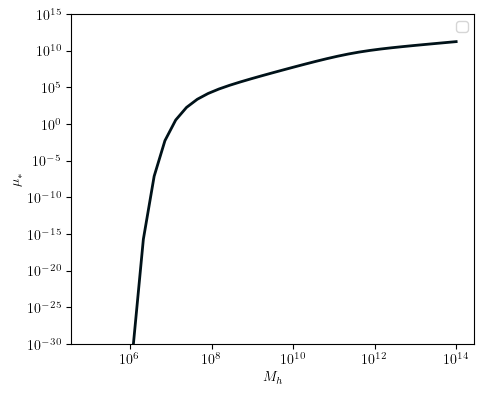

In [19]:
mu_M = zeus21.sfrd.fstarofz(AstroParams_stoch, CosmoParams_use, 10., Mh) * np.exp(-zeus21.sfrd.Matom(10.)/Mh) * Mh

plt.figure(figsize=(5,4))
plt.loglog(Mh,mu_M,color=colors[0])
plt.legend()
plt.xlabel(r'$M_h$')
plt.ylabel(r'$\mu_{*}$')
plt.tight_layout()
plt.ylim(1e-30,1e15)
plt.savefig('./mu_star.png')
plt.show()

In [4]:
SFR_stoch = zeus21.sfrd.SFR_II(AstroParams_stoch,CosmoParams_use,HMFintclass_use,HMFintclass_use.Mhtab[np.newaxis,:],np.array((10.,11))[:,np.newaxis],0.)
SFR = zeus21.sfrd.SFR_II(AstroParams,CosmoParams_use,HMFintclass_use,HMFintclass_use.Mhtab[np.newaxis,:],np.array((10.,11))[:,np.newaxis],0.)

(1e-25, 1e+20)

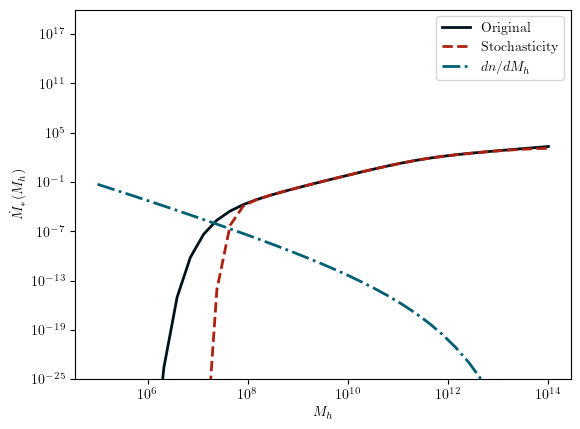

In [5]:
plt.loglog(HMFintclass_use.Mhtab,SFR[0],label=r'$\rm Original$')
plt.loglog(HMFintclass_use.Mhtab,SFR_stoch[0],label=r'$\rm Stochasticity$',c=colors[-2],ls='--')

plt.loglog(HMFintclass_use.Mhtab,np.exp(HMFintclass_use.logHMFint((np.log(HMFintclass_use.Mhtab), 10.))),label=r'$dn/dM_h$',ls='-.')

plt.xlabel(r'$M_h$')
plt.ylabel(r'$\dot{M}_*(M_h)$')
plt.legend()
plt.ylim(1e-25,1e20)

In [5]:
ZMIN = 10.0 #down to which z we compute the evolution
CoeffStructure_21 = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams, HMFintclass_use, zmin=ZMIN)
CoeffStructure_21_stoch = zeus21.get_T21_coefficients(CosmoParams_use, ClassyCosmo_use, AstroParams_stoch, HMFintclass_use, zmin=ZMIN)

In [6]:
bar_SFRD = CoeffStructure_21.SFRDbar2D_II
bar_SFRD_stoch = CoeffStructure_21_stoch.SFRDbar2D_II

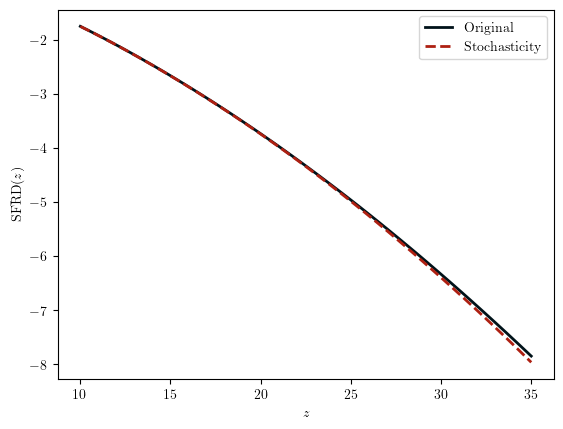

In [7]:
plt.plot(CoeffStructure_21.zintegral,np.log10(bar_SFRD[:,0]),label=r'$\rm Original$')
plt.plot(CoeffStructure_21.zintegral,np.log10(bar_SFRD_stoch[:,0]),label=r'$\rm Stochasticity$',c=colors[-2],ls='--')

plt.xlabel(r'$z$')
plt.ylabel(r'$\bar{\rm SFRD}(z)$')
plt.legend()
# plt.ylim(-5,-1)
# plt.xlim(5,16)


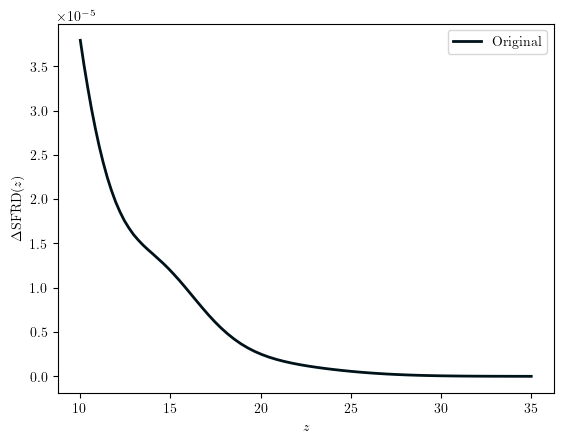

In [8]:
plt.plot(CoeffStructure_21.zintegral,abs(bar_SFRD[:,0]-bar_SFRD_stoch[:,0]),label=r'$\rm Original$')

plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta\bar{\rm SFRD}(z)$')
plt.legend()

Text(0, 0.5, '$T_{21} \\,[muK^2]$')

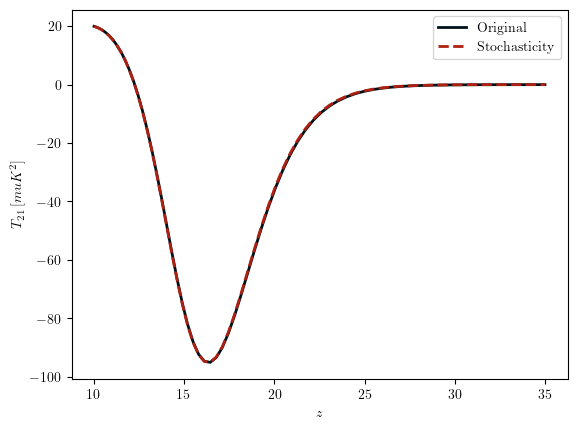

In [9]:
plt.plot(CoeffStructure_21.zintegral,CoeffStructure_21.T21avg,label=r'$\rm Original$')
plt.plot(CoeffStructure_21_stoch.zintegral,CoeffStructure_21_stoch.T21avg,label=r'$\rm Stochasticity$',c=colors[-2],ls='--')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$T_{21} \,[muK^2]$')


Text(0, 0.5, '$\\Delta T_{21}/T_{21}$')

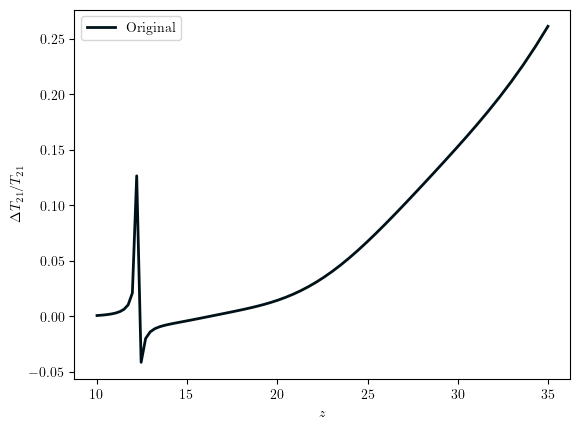

In [10]:
plt.plot(CoeffStructure_21.zintegral,(CoeffStructure_21.T21avg-CoeffStructure_21_stoch.T21avg)/CoeffStructure_21.T21avg,label=r'$\rm Original$')
plt.legend()
plt.xlabel(r'$z$')
plt.ylabel(r'$\Delta T_{21}/T_{21}$')
